# Ames, Iowa Housing Price Predictions

### Overview
I completed this project as part of a Kaggle competition (see here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques). I visualized the various aspects of the dataset prior to cleaning null values, feature engineering, and creating an ensemble model. 

I generated ensemble predictions with the the Extreme Gradient Boosting (XGBoost) decision-tree algorithm and Ridge regression. Prior to creating the XGBoost model, I performed hyper-parameter grid search optimization to prevent over-fitting the training data during cross-validation. 

The metric used for scoring by Kaggle is the root mean squared logarithmic error (RMSLE). This metric is similar to the more common root mean squared error, but does not penalize as heavily for extreme differences between actual and predicted values due to the logarithm. 

The RMSLE for out-of-sample data with 10-fold cross-validation on the training set was 0.1129 and 0.1096 for the XGBoost and Ridge model respectively. Each model scored approximately 0.1220 separately on the un-labeled test set from Kaggle (with the Ridge performing slightly better). Combined, the models gave a final RMSLE was 0.11775 for the Kaggle test set. When comparing my final result to other Kaggle competitors, my model places within the top 15% (~365 out of 2410) as of November 16th, 2017 (username: markborysi). 

Additional work with feature engineering, including more models to the ensemble, and improving the replacement of null values / outliers could potentially further improve this model.

### Key Results
My RMSLE of 0.11775 would place ~365 out of 2410 entries (top 15%) as of November 16th, 2017.

### Methods used
- seaborn for feature visualization
- pandas dummy variables for transforming nominal features
- XGBoost modeling and predictions
- Ridge Regression
- Grid-search parameter optimization

# Reading in the Provided Dataset
The dataset contains roughly 3000 entries with various features that describe the house. The training set contain 1460 labeled samples with the final sale price, while the test set contains 1459 samples without the target sale price. The dataset was compiled by Dean De Cock: https://ww2.amstat.org/publications/jse/v19n3/decock.pdf. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import KFold

train = pd.read_csv('train.csv')
train = train.drop('Id', axis=1)
test = pd.read_csv('test.csv')
test = test.drop('Id', axis=1)

print('train rows and features:', train.shape)
print('test rows and features:', test.shape)
train.head()

train rows and features: (1460, 80)
test rows and features: (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Plotting the target variable—Sale Price
The sale price shows a slight skew towards higher prices, with a few potential outliers. Log transforming the data and removing a few high-value outliers improves normality.

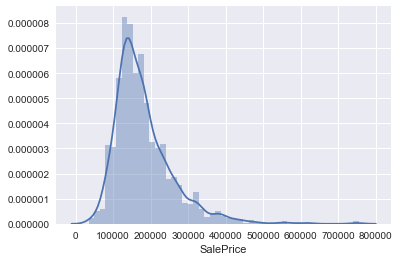

In [3]:
sns.distplot(train.SalePrice);

In [4]:
train = train[train.SalePrice < 500000].reset_index(drop=True)

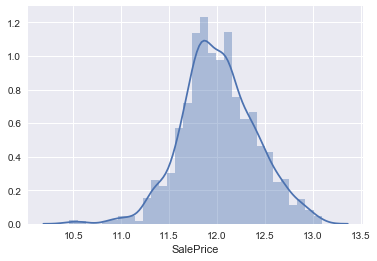

In [5]:
sns.distplot(np.log(train.SalePrice))

# Visualizing Feature Correlations with Seaborn Heatmap
While there are some features with high multicollinearity, overall the features appear to be relatively independent. Also note that this plot only shows the numerical features from the dataset. The dataset contains 80 features, but only 36 are numerical. The remaining 44 nominal features will be dealth with later on. 

### Top 15 Features with Highest Correlation with Sale Price
Below the top 15 feature correlations with the target are shown. Overall quality, Living Area, Garage Area, and Basement size all seems to correlate strongly with the final sale price. The next few plots will show distributions with these features and the target Sale Price.

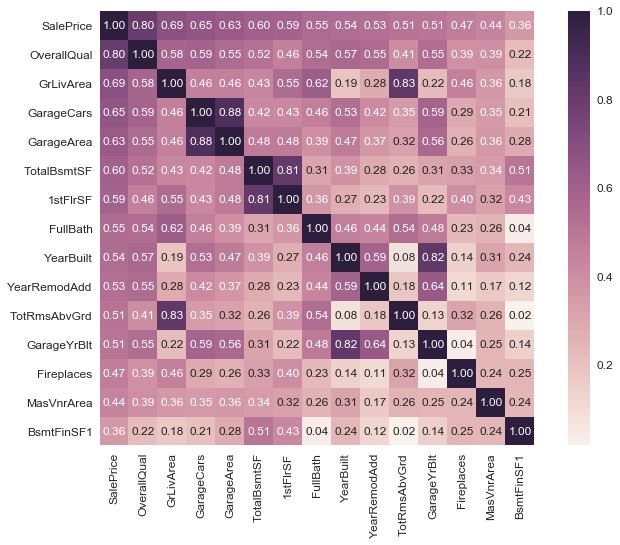

In [6]:
plt.figure(figsize=(12,8))
k = 15
corrmat = abs(train.corr())
cols_large = corrmat.nlargest(k, 'SalePrice').index
hm_large = corrmat.nlargest(k,'SalePrice')[cols_large]
sns.set(font_scale=1.2)
sns.heatmap(hm_large, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12})

# Visualizing Important Features and Removing Outliers

### Overal Quality Score

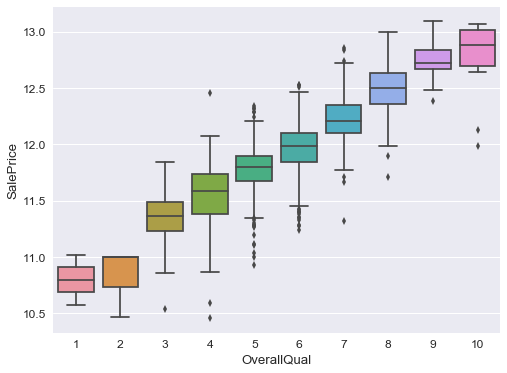

In [7]:
var = 'OverallQual'
data_plot = pd.concat([np.log(train['SalePrice']), train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data_plot)

### Above Ground Living Area

There are a few outliers in the first plot, which the dataset author notes are due to short sales. I filtered the 2 houses with living area above 4000 to prevent them from skewing the final results.

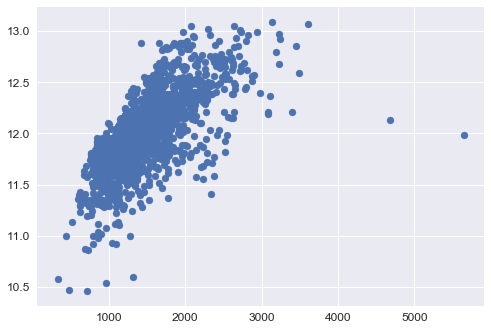

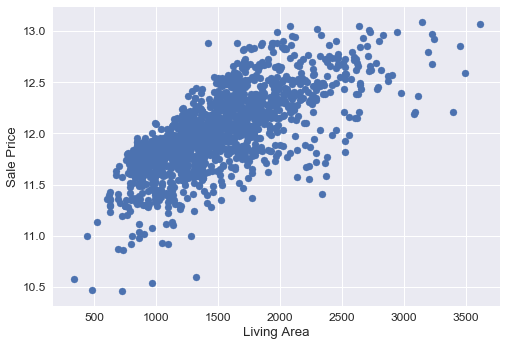

(1449, 80)

In [8]:
plt.scatter(train['GrLivArea'], np.log(train.SalePrice))
plt.show()
plt.xlabel('Living Area'), plt.ylabel('Sale Price')
train = train[train['GrLivArea'] < 4000].reset_index(drop=True)
plt.scatter(train['GrLivArea'], np.log(train.SalePrice))
plt.show()
train.shape

### Garage Area
The outliers at the higher end are not as drastic as shown previously, but I chose to filter at 1200 sq ft. Further, the number of houses without a garage shows an interesting trend.

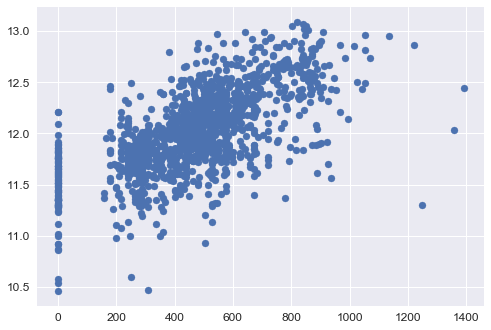

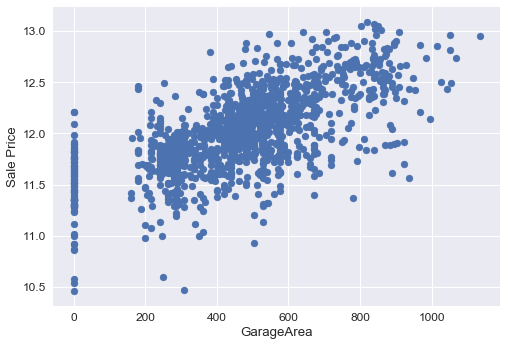

(1445, 80)

In [9]:
plt.scatter(train['GarageArea'], np.log(train.SalePrice))
plt.show()
plt.xlabel('GarageArea'), plt.ylabel('Sale Price')
train = train[train['GarageArea'] < 1200].reset_index(drop=True)
plt.scatter(train['GarageArea'], np.log(train.SalePrice))
plt.show()
train.shape

### Total Basement Square Feet

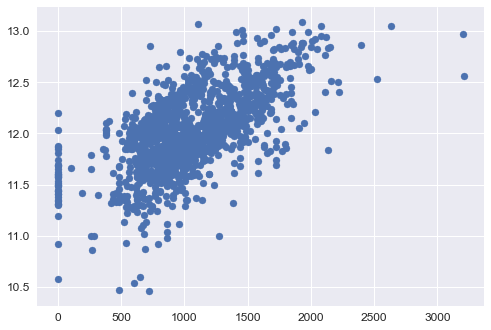

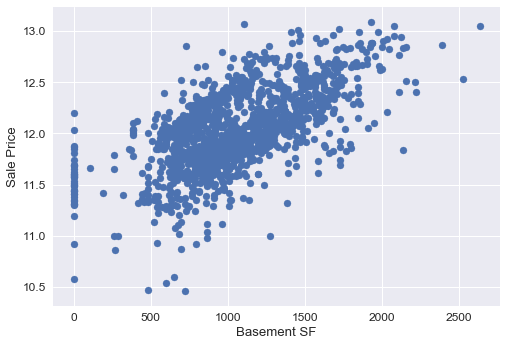

(1443, 80)

In [10]:
plt.scatter(train['TotalBsmtSF'], np.log(train.SalePrice))
plt.show()
plt.xlabel('Basement SF'), plt.ylabel('Sale Price')
train = train[train['TotalBsmtSF'] < 3000].reset_index(drop=True)
plt.scatter(train['TotalBsmtSF'], np.log(train.SalePrice))
plt.show()
train.shape

### Total Lot Area
Here I filtered at 40,000 sq. ft, which removed a few of the more drastic outliers.

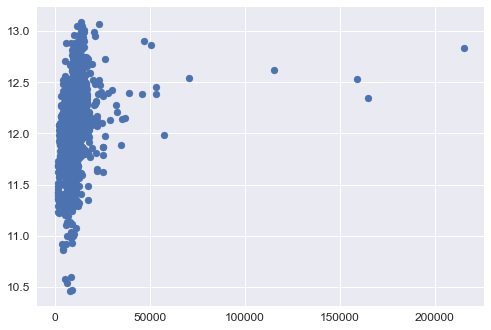

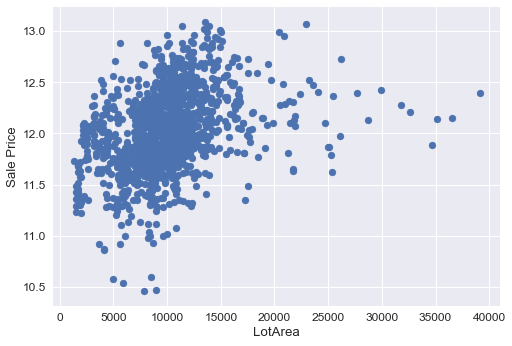

(1432, 80)

In [11]:
plt.scatter(train['LotArea'], np.log(train.SalePrice))
plt.show()

train = train[train['LotArea'] < 40000].reset_index(drop=True)
plt.scatter(train['LotArea'], np.log(train.SalePrice))
plt.xlabel('LotArea'), plt.ylabel('Sale Price')
plt.show()
train.shape

# Engineering New Features

In [12]:
train_length = train.shape[0]
combined = pd.concat([train, test], axis=0).reset_index(drop=True)

### Age Since Remodel and Built
I ended up combining the years since the house was built and years since the house was remodeled into a single metric that represents both of these together. It shows a higher correlation in the 2nd plot below.

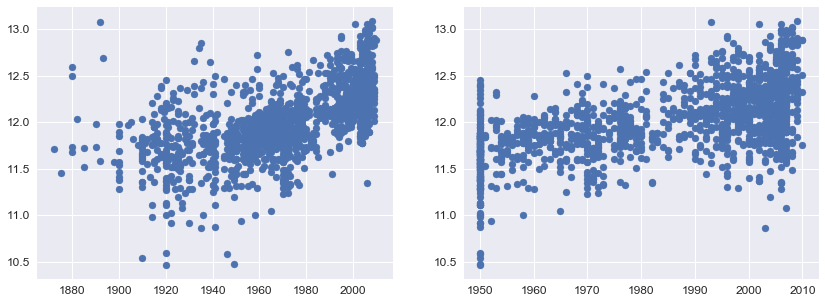

In [13]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(train['YearBuilt'], np.log(train.SalePrice))
ax2.scatter(train['YearRemodAdd'], np.log(train.SalePrice))
plt.show()

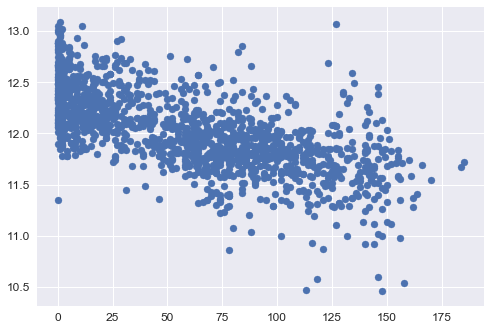

In [14]:
combined['age_sale_remodel'] = (combined['YrSold'] - combined['YearRemodAdd']) + (combined['YrSold'] - combined['YearBuilt'])
plt.scatter(combined['age_sale_remodel'], np.log(combined.SalePrice))
plt.show()

### Total square footage, including garage and basement
I also created a total square footage that includes the garage, basement, and above ground living area.

(<matplotlib.text.Text at 0x118639400>, <matplotlib.text.Text at 0x118b5e940>)

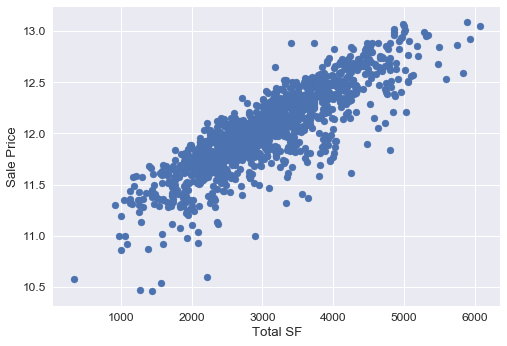

In [15]:
combined["totalSF"] = combined["TotalBsmtSF"] + combined["1stFlrSF"] + combined["2ndFlrSF"] + combined['GarageArea']
plt.scatter(combined['totalSF'], np.log(combined.SalePrice))
plt.xlabel('Total SF'), plt.ylabel('Sale Price')

### Square footage normalized by quality

Here, I created a metric that normalizes the size of the house by the quality of the house. It shows a very high correlation with the sale price.

(<matplotlib.text.Text at 0x1141c9668>, <matplotlib.text.Text at 0x11879dba8>)

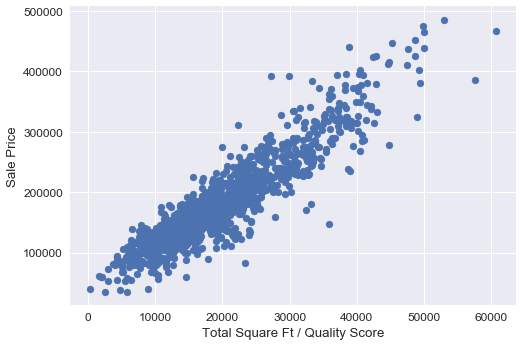

In [16]:
combined['sq_ft_quality'] = combined['totalSF'] / (1/combined['OverallQual'])
plt.scatter(combined['sq_ft_quality'], combined.SalePrice)
plt.xlabel('Total Square Ft / Quality Score'), plt.ylabel('Sale Price')

The new features correlate well with the target and show up in the top 15 features.

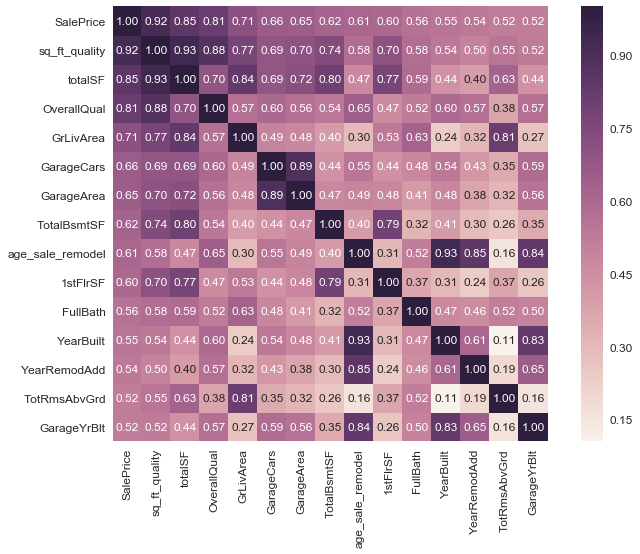

In [17]:
plt.figure(figsize=(12,8))
k = 15
corrmat = abs(combined.corr())
cols_large = corrmat.nlargest(k, 'SalePrice').index
hm_large = corrmat.nlargest(k,'SalePrice')[cols_large]
sns.set(font_scale=1.2)
sns.heatmap(hm_large, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12})

# Missing Values and Converting Nominal to Ordinal
Below, I show the missing values for the object features. There are a high number of missing features, which is typically due to the house not having that particular object (e.g. a fireplace).

In [18]:
combined_objects = combined.select_dtypes(include=['object'])
print('number of object features:', combined_objects.shape[1])

number of object features: 43


In [19]:
combined_objects.isnull().sum()[combined_objects.isnull().sum()>0]

Alley           2693
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      79
BsmtQual          81
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2321
FireplaceQu     1419
Functional         2
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
KitchenQual        1
MSZoning           4
MasVnrType        24
MiscFeature     2789
PoolQC          2883
SaleType           1
Utilities          2
dtype: int64

I decided to remove a few of the nominal features that provided little information.

In [20]:
del combined['Alley']
del combined['MiscFeature']
del combined['PoolQC']
del combined['MSSubClass']

Many nominal features had a breakdown from excellent to poor, as shown below. For these, I changed the variable to ordinal, with a score of 0–5.

In [21]:
combined.FireplaceQu.value_counts()

Gd    727
TA    584
Fa     73
Po     46
Ex     42
Name: FireplaceQu, dtype: int64

In [22]:
ordinal_cols = ['FireplaceQu', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
               'HeatingQC', 'ExterQual', 'ExterCond', 'KitchenQual']
for col in ordinal_cols:
    combined[col] = combined[col].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}).fillna(0)

Other nominal features had ordering to them, but not in the same poor to excellent scale. For these, I manually looked at the descriptions of the features and replaced them with ordinal values, where possible.

In [23]:
combined.Fence.value_counts()

MnPrv    328
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64

In [24]:
combined['BsmtFinType1'] = combined['BsmtFinType1'].replace({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf':1}).fillna(0)
combined['BsmtFinType2'] = combined['BsmtFinType2'].replace({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf':1}).fillna(0)
combined['BsmtExposure'] = combined['BsmtExposure'].replace({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1}).fillna(0)

combined['Fence'] = combined['Fence'].replace({'GdPrv': 2, 'GdWo': 2, 'MnPrv': 1, 'MnWw': 1}).fillna(0)
combined['GarageType'] = combined['GarageType'].replace({'2Types': 5, 'Attchd': 4, 'BuiltIn': 4, 'Basment': 3, 'CarPort':2, 'Detchd':2}).fillna(0)
combined['GarageFinish'] = combined['GarageFinish'].replace({'Fin': 3, 'RFn': 2, 'Unf': 1}).fillna(0)

combined['HouseStyle'] = combined['HouseStyle'].replace({'1Story':1, '1.5Fin':1.5, '1.5Unf':1.25, '2Story': 2, '2.5Fin':2.5, '2.5Unf':2.25, 'SFoyer': 1.25, 'SLvl': 1.25})
combined['BldgType'] = combined['BldgType'].replace({'1Fam': 3, '2FmCon': 2, 'Duplx': 2, 'TwnhsE': 1.5, 'TwnhsI': 1})

The remaining null values are relatively minimal compared to the start.

In [25]:
combined_objects = combined.select_dtypes(include=['object'])
print('number of object features:', combined_objects.shape[1])
combined_objects.isnull().sum()[combined_objects.isnull().sum()>0]

number of object features: 24


Electrical      1
Exterior1st     1
Exterior2nd     1
Functional      2
MSZoning        4
MasVnrType     24
SaleType        1
Utilities       2
dtype: int64

### Get dummies and creating target and features
The remaining nominal features will be transformed using get_dummies. It ends up producing 164 dummy features, which is much reduced from 280 that would have occurred if I did not transfrom some to ordinal above. I also created one final new feature using the new ordinal features, which is the total quality that combined kitchen, exterior, and overall quality. Finally, the dataframe with numerical and dummy features is created.

In [26]:
dummies = pd.get_dummies(combined_objects)
print('number of dummies features:', dummies.shape[1])

number of dummies features: 164


In [27]:
combined['total_quality'] = combined['KitchenQual'] + 2*combined['ExterQual'] + 2*combined['OverallQual']

In [29]:
combined_new = pd.concat([combined_numeric, dummies], axis=1)
print('samples and features in data set:', combined_new.shape)

samples and features in data set: (2891, 220)


### Filling in remaining null values

The majority of the null values remaining are numerical variables, where the house does not have the feature (e.g. a garage). For these, I replaced with the minimum value in the series.

In [30]:
combined_new.isnull().sum()[combined_new.isnull().sum()>0]

BsmtFinSF1          1
BsmtFinSF2          1
BsmtFullBath        2
BsmtHalfBath        2
BsmtUnfSF           1
GarageArea          1
GarageCars          1
GarageYrBlt       159
LotFrontage       478
MasVnrArea         23
SalePrice        1459
TotalBsmtSF         1
totalSF             2
sq_ft_quality       2
dtype: int64

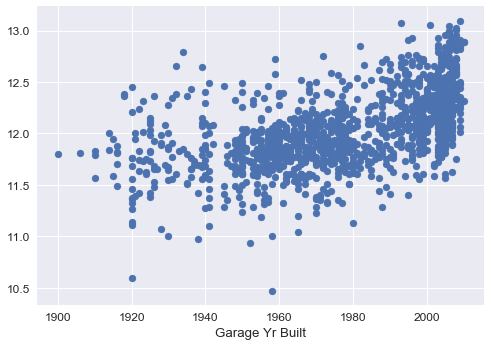

In [31]:
plt.scatter(combined_new.GarageYrBlt, np.log(combined_new.SalePrice))
plt.xlabel('Garage Yr Built')

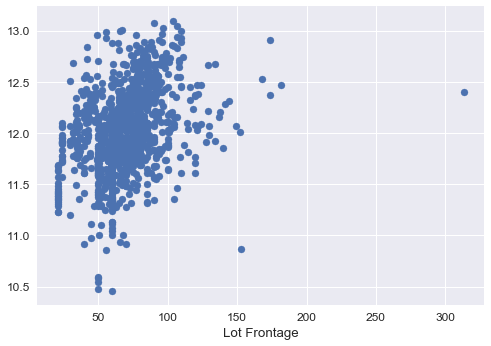

In [32]:
plt.scatter(combined_new.LotFrontage, np.log(combined_new.SalePrice))
plt.xlabel('Lot Frontage')

In [33]:
combined_new['GarageYrBlt'] = combined_new['GarageYrBlt'].fillna(combined_new.GarageYrBlt.min())
combined_new['LotFrontage'] = combined_new['LotFrontage'].fillna(combined_new.LotFrontage.min())
combined_new['GarageYrBlt'] = combined_new['GarageYrBlt'].replace({2207:2006})

In [34]:
combined_new.isnull().sum()[combined_new.isnull().sum()>0]

BsmtFinSF1          1
BsmtFinSF2          1
BsmtFullBath        2
BsmtHalfBath        2
BsmtUnfSF           1
GarageArea          1
GarageCars          1
MasVnrArea         23
SalePrice        1459
TotalBsmtSF         1
totalSF             2
sq_ft_quality       2
dtype: int64

At this point, all null values have been replaced. The heatmap below shows one final look at the target correlations for all features. Some of the engineered features highly correlate with the target, but also show high multicollinearity. However, the grid-search optimization of the XGBoost model will be conservatively trained to prevent over-fitting, and Ridge regression will also include regularization.

In [35]:
combined_new = combined_new.fillna(combined_new.mean())
combined_new.isnull().sum()[combined_new.isnull().sum()>0]

Series([], dtype: int64)

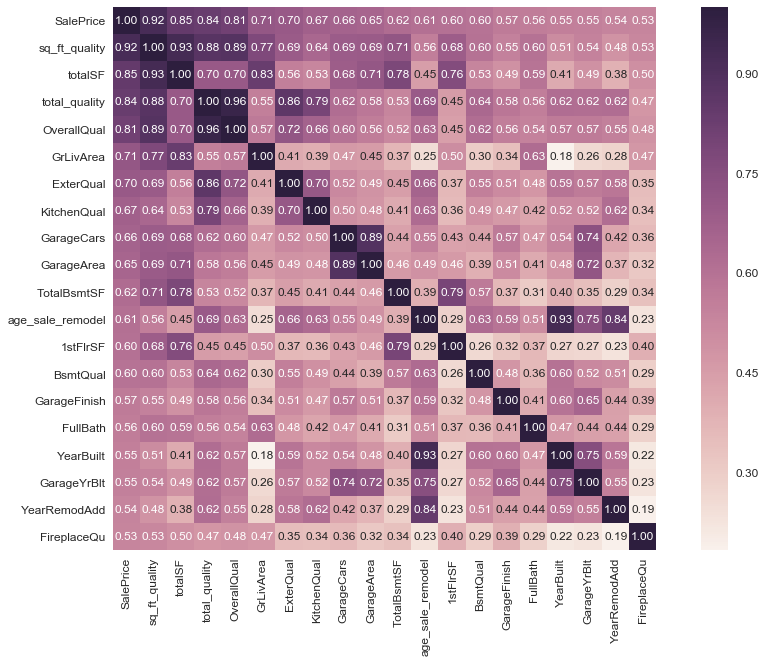

In [74]:
plt.figure(figsize=(16,10))
k = 20
corrmat = abs(combined_new.iloc[:1432, :].corr())
cols_large = corrmat.nlargest(k, 'SalePrice').index
hm_large = corrmat.nlargest(k,'SalePrice')[cols_large]
sns.set(font_scale=1.2)
sns.heatmap(hm_large, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12})

# Creating train and prediction datasets, as well as filtering by correlation

The features are split based on the labeled training set and unlabeled testing set provide by Kaggle.

In [36]:
X = combined_new.iloc[:train_length, :].drop('SalePrice', axis=1)
y = combined_new.SalePrice[:train_length]
print('samples and features in train set:', X.shape)

X_predict = combined_new.iloc[train_length:, :].drop('SalePrice', axis=1)
print('samples and features in predict set:', X_predict.shape)

samples and features in train set: (1432, 219)
samples and features in predict set: (1459, 219)


This function allows for filtering the data based on correlation with the target. All samples will be used for optimizing XGBoost, but a conservative approach will be taken to prevent overfitting. However, correlation filtering will be used for Ridge regression later on.

In [37]:
def select_features(X, y, corr_value):

    ## filters columns based on their correlation with the target
    for col in X.columns:
        corr = pearsonr(X[col], y)
        if abs(corr[0]) < corr_value:
            del X[col]
            
    return X

The number of samples and features in the training and prediction datasets are shown below for XGBoost optimization.

In [38]:
X = select_features(X, y, 0)
X_predict = X_predict[X.columns]

print('samples and features in train set:', X.shape)
print('samples and features in predict set:', X_predict.shape)

samples and features in train set: (1432, 219)
samples and features in predict set: (1459, 219)


/Users/Mark/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


# Grid Search Parameter Tuning
Below, a set of four functions are given that will be used to optimize hyperparameters for the XGBoost model. The first function calculates the root-mean-square-log-error (RMSLE), which is the error metric used by Kaggle. 

The second error function is more unique in that evaluates the performance of each set of hyperparameters based not only on the out-of-sample rmsle, but also on the difference in errors between the out-of-sample data and in-sample data.

Concretely, it uses: 

weight\*test_error + (test_error - train_error),

as an evaluation metric. This optimizes for low out-of-sample errors, but also prevents XGBoost from severly overfitting the data so that it can better generalize for the unlabeled Kaggle test set. The weight value allows the user to specify how much weight to place on the actual value of the out-of-sample error vs. the difference in test-train error.

### Defining error metrics and functions

In [75]:
## function for calculating the RMSLE for a predicted and actual dataset

def rmsle(predicted, actual):
    
    # converting xgb dmatrix to np array, if necessary
    try:
        actual = actual.get_label()
    except:
        pass
    
    assert(len(predicted) == len(actual))
    
    # taking the log of predictios and actual values
    p = np.log(np.array(predicted) + 1)
    a = np.log(np.array(actual) + 1)
    
    # calculating rmse with the logarithm values
    result = (((p - a)**2).sum() / len(predicted))**0.5
    return 'error', result

In [40]:
def error_evaluation(results, count, test_weight):
    
    # pull out train and test errors, calculate error difference metric
    train = np.array(results['train']['error'])
    test = np.array(results['test']['error'])
    test_plus_diff = test_weight*test + (test-train)
    
    # find the best difference value and index
    best_diff = np.min(test_plus_diff)
    best_diff_idx = np.argmin(test_plus_diff)
    
    # create a series with the best error metric and index
    labels = ['rounds', 'error_diff', 'test_error', 'train_error']
    metrics = [best_diff_idx, best_diff, test[best_diff_idx], train[best_diff_idx]]
    result_series = pd.Series(metrics, index=labels, name=count)
    
    return result_series

### K-fold Cross Validation of XGBoost 
This function simply performs K-fold cross validation XGBoost modeling for a given set of hyperparameters. The output is a dataframe that gives the error metric previously described, as well as train and test errors, and the number of rounds to reach the optimal solution.

In [41]:
def k_fold_xgboost(X, y, X_predict, params, num_folds, boost_round, stop_round, test_weight):
    
    import xgboost as xgb

    # initialize dataframe for result storage
    df_results = pd.DataFrame()
    df_predictions = pd.DataFrame()
    count = 0
    
    # getting k-folds
    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1)

    for train_index, test_index in folds.split(range(0, X.shape[0])):
    
        # using the train and test indices from k-fold split to subset train and test data
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        
        # converting X and y into DMatrix
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # XGBoost modeling
        results={}
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=boost_round,
            evals=[(dtest, 'test'), (dtrain, 'train')],
            early_stopping_rounds=stop_round,
            evals_result = results,
            feval = rmsle,
            verbose_eval=False,
        )
        
        # calculating and storing error metrics
        result_series = error_evaluation(results, count, test_weight)
        df_results = df_results.append(result_series)
        
        
        # making predictions on prediction set
        try:
            dpredict = xgb.DMatrix(X_predict)
            boost_predict = model.predict(dpredict)
            boost_predict = pd.Series(boost_predict, name=count)
            df_predictions = df_predictions.append(boost_predict)
        except:
            pass
        
        count+=1
    return df_results, model, df_predictions

### Grid Search Parameter Optimization of XGBoost
The grid search function below takes in different parameters to be tuned for XGBoost, along with the desired ranges. It then trains and evaluates a k-fold model for each set of hyperparameters in the given range. It acts as a factorial design evaluation of the parameters. The returned results give relevant error metrics for each iteration of hyperparameters in the experimental design.

In [76]:
def grid_search_xgboost(X, y, params_initial, gridsearch_params, num_fold, boost_round, stop_round, test_weight):
    
    # Initialize results dataframe and trial counts
    params = params_initial
    count = 0
    results = pd.DataFrame()
    
    # the parameters that will be varied
    for max_depth, subsample, min_child_weight, reg_lambda in gridsearch_params:

        # Update parameters
        params['max_depth'] = max_depth
        params['subsample'] = subsample
        params['min_child_weight'] = min_child_weight
        params['reg_lambda'] = reg_lambda

        # kfold xgboost modeling
        X_predict = pd.DataFrame()
        kfold_results, model, null_predict = k_fold_xgboost(X, y, X_predict, params, num_fold, boost_round, stop_round, test_weight)
    
        # obtain names and values for hyperparams
        keys = list(params.keys())
        vals = [val for val in params.values()]
        param_values = pd.Series(vals, index=keys, name=count)
        
        # concat current parameters with results
        boost_results = pd.Series(kfold_results.mean(), name=count)
        combined_results = pd.concat([param_values, boost_results], axis=0)
        
        # add results to dataframe
        results = results.append(combined_results)
        count += 1
    
    # select relevant results and sort by best error results
    results = results[['rounds', 'error_diff', 'test_error', 'train_error', 'max_depth', 
                       'min_child_weight', 'subsample', 'reg_lambda']].sort_values('error_diff')

    return results

### Running the Grid Search
Detailing the initial parameters that will be studied.

In [43]:
params_initial = {
    # Parameters to initially tune (set to defaults):
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'reg_alpha': 0,
    'reg_lambda': 1,
    
    # Other parameters:
    'objective':'reg:linear',
    'eta': 0.15,
}

The code block below shows which parameters will be varied and the ranges. Overall, this experimental design results in 16 different hyperparameter combinations. Here, I looked at: 
- max_depth: the depth of trees being created
- subsample: number of samples to use for creating each tree
- min_child_weight: the weight of each feature required for splitting
- reg_lambda: lambda regularization
I tried to choose relatively conservative values for each hyperparameter to prevent creating a model with too much variance.

In [47]:
params = params_initial

# parameters to vary in gridsearch
gridsearch_params = [
    (max_depth, subsample, min_child_weight, reg_lambda)
    for max_depth in range(3, 5, 1)
    for subsample in np.arange(.4, 0.81, 0.4)
    for min_child_weight in range(3, 10, 6)
    for reg_lambda in range(1, 11, 9)
]
print('number of parameter combinations:', len(gridsearch_params))

number of parameter combinations: 16


The code block below lists a few additional inputs such as the number of cross-validation folds, the number of boost rounds, stop rounds, and how heavily to weight the test results compared to the train/test error difference. I chose short boost rounds because the model tended to overfit past 100 rounds. The test weight of 2 relies more heavily on the train/test difference than the test error itself.

In [48]:
# additional xgboost parameters
num_fold = 10
boost_round = 80
stop_round = 5
test_weight = 2

results = grid_search_xgboost(X, y, params, gridsearch_params, num_fold, boost_round, stop_round, test_weight)

/Users/Mark/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Below is a sample of the output for each combination of studied factors. The error diff shows 2\*test_error + (test_error-train_error). The results show relatively good bias/variance balance. A few trends also begin to emerge, such as low max_depth, high child_weight, and low subsample as being more optimal. I will plot the general results in a few code blocks.

In [49]:
results.head(10)

,rounds,error_diff,test_error,train_error,max_depth,min_child_weight,subsample,reg_lambda
3,63.2,0.254721,0.119625,0.104154,3.0,9.0,0.4,10.0
2,48.1,0.257371,0.121086,0.105889,3.0,9.0,0.4,1.0
11,62.1,0.261401,0.119426,0.096876,4.0,9.0,0.4,10.0
0,42.7,0.262609,0.122299,0.104289,3.0,3.0,0.4,1.0
7,65.0,0.262835,0.120621,0.099027,3.0,9.0,0.8,10.0
8,39.3,0.264419,0.119137,0.092993,4.0,3.0,0.4,1.0
6,53.4,0.264570,0.121300,0.099329,3.0,9.0,0.8,1.0
4,55.3,0.264993,0.119707,0.094128,3.0,3.0,0.8,1.0
1,67.3,0.265759,0.121969,0.100150,3.0,3.0,0.4,10.0
10,36.7,0.266428,0.121932,0.099366,4.0,9.0,0.4,1.0


The function below takes in the factorial experiment and creates a plot of the coefficients for each factor (including binary interactions). It will assist in further fine-tuning the parameters.

In [50]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

def regression_fit_plot(df, target, alpha, show_plot):
    
    # specifying target and features
    X = df.drop(['train_error', 'test_error', 'error_diff', 'rounds'], axis=1)
    y = df[target]

    # creating binary interaction terms
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    poly_features = poly.fit_transform(X)
    poly_names = poly.get_feature_names(X.columns)
    poly_X = pd.DataFrame(poly_features, columns=poly_names)
    
    from sklearn.linear_model import Ridge

    X_norm = (poly_X - poly_X.min()) / (poly_X.max() - poly_X.min())
    model = Ridge(alpha=alpha).fit(X_norm, y)
    m = model.coef_
 
    # making the plot of coefficient
    if show_plot == True:
        #del m['const']

        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(1,1,1)
        ax.bar(range(len(m)), m, 0.5,  color='blue',)
        ax.set_xticks(range(len(m)))
        ax.set_xticklabels(poly_X.columns, rotation = 90)
        plt.ylabel('Correlation Coefficients')
        plt.show()

/Users/Mark/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


As shown below, max_depth, subsample, and min_child_weight are all dominant factors. Further, a number of binary interactions are also important, with the most important being a combination of max_depth and subsample (which makes sense because they are significant individually as well).

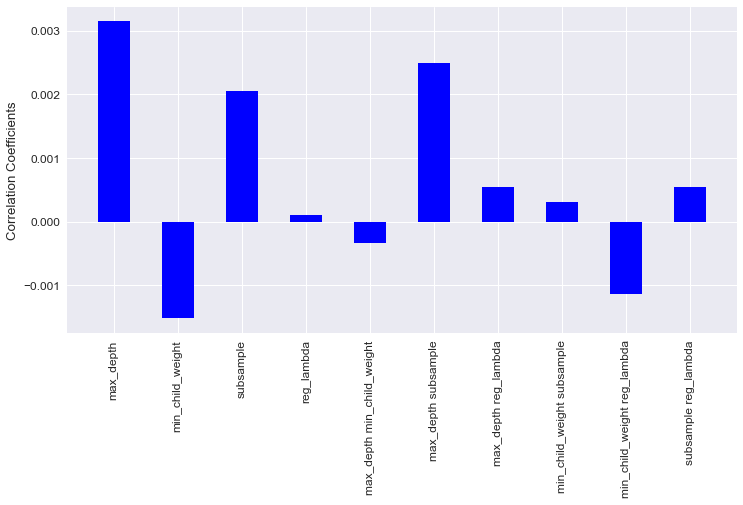

In [52]:
target = 'error_diff'
alpha = 5
show_plot = True

regression_fit_plot(results, target, alpha, show_plot)

Finally, the mean values from the initial gridsearch are shown for the 5 best results. These will serve as guides to create a second, more fine-tuned search.

In [54]:
results.head(5).mean()

rounds              56.220000
error_diff           0.259787
test_error           0.120612
train_error          0.102047
max_depth            3.200000
min_child_weight     7.800000
subsample            0.480000
reg_lambda           6.400000
dtype: float64

### Finetuning critical parameters

The most critical parameters from above will be further optimized based on the initial results. I tried to tend the ranges in the direction of importance for the plot below and the average values of the best results. In general:
- max_depth = down
- subsample = down
- min_child_weight = up
- lambda = about the same

The first three parameters all tend to create models with less variance, which is very important based on my experience with this problem.

In [55]:
params = params_initial

num_boost_round = 1000

gridsearch_params = [
    (max_depth, subsample, min_child_weight, reg_lambda)
    for max_depth in range(2, 4, 1)
    for subsample in np.arange(.3, .61, 0.3)
    for min_child_weight in range(6, 13, 6)
    for reg_lambda in range(3, 9, 5)
]
len(gridsearch_params)

16

Below I performed the 2nd round of hyperparameter optimization. This time, I increased the number of rounds to 150 and changed the test error weight from 2 to 10. These changes will serve to place more importance on the out-of-sample test error, compared to the difference between train and test errors. My hope is that the model is already conservative enough to prevent extreme variance and am now aiming to maximize out-of-sample performance.

In [56]:
# additional xgboost parameters
num_fold = 10
boost_round = 150
stop_round = 5
test_weight = 10

results = grid_search_xgboost(X, y, params, gridsearch_params, num_fold, boost_round, stop_round, test_weight)

The results below show lower testing errors, but also larger gaps between train and test error. However, the results don't appear to be too overfit. For reference, the best test error of 0.112888 would place in the top 5% in Kaggle, while the best test error from the initial search (~0.119) would place in the top 30%. This assumes equal performance on the un-labeled dataset (which doesn't end up being the case).

In [57]:
results.head(10)

,rounds,error_diff,test_error,train_error,max_depth,min_child_weight,subsample,reg_lambda
12,117.8,1.160152,0.112888,0.081613,3.0,6.0,0.6,3.0
14,132.3,1.174659,0.114331,0.082986,3.0,12.0,0.6,3.0
15,134.0,1.191812,0.116102,0.085305,3.0,12.0,0.6,8.0
13,129.2,1.192669,0.115964,0.082930,3.0,6.0,0.6,8.0
8,101.3,1.199886,0.117603,0.093746,3.0,6.0,0.3,3.0
6,135.1,1.207104,0.118630,0.097827,2.0,12.0,0.6,3.0
4,117.8,1.207205,0.118839,0.100027,2.0,6.0,0.6,3.0
7,135.1,1.209137,0.119024,0.100125,2.0,12.0,0.6,8.0
9,101.6,1.209551,0.118679,0.095915,3.0,6.0,0.3,8.0
11,118.3,1.209573,0.118842,0.097692,3.0,12.0,0.3,8.0


In this case, the directionality of the coefficients has flipped from the initial search, showing that the hyperparameters are nearing a minima. I will simply use the best result from this round for further evaluation, but another fine-tuning could be performed.

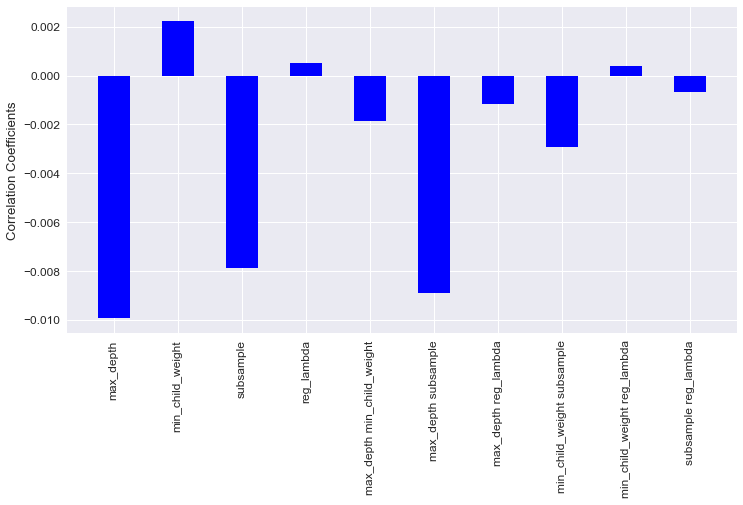

In [58]:
target = 'error_diff'
alpha = 5
show_plot = True

regression_fit_plot(results, target, alpha, show_plot)

# Machine Learning Modeling and Predictions

## XGBoost Model
Using the optimized hyper-parameters, I will train an XGBoost model and use it to predict the prices for the un-labeled prediction set. As a reminder, the mean values of the 5 best results from the optimization are shown below.

In [59]:
results.head(5).mean()

rounds              122.920000
error_diff            1.183836
test_error            0.115377
train_error           0.085316
max_depth             3.000000
min_child_weight      8.400000
subsample             0.540000
reg_lambda            5.000000
dtype: float64

Creating the training set for cross-validation training with target, as well as the prediction dataset.

In [60]:
X = combined_new.iloc[:train_length, :].drop('SalePrice', axis=1)
y = combined_new.SalePrice[:train_length]
X_predict = combined_new.iloc[train_length:, :].drop('SalePrice', axis=1)

X = select_features(X, y, 0).astype('float')
X_predict = X_predict[X.columns].astype('float')

print('samples and features in train set:', X.shape)
print('samples and features in predict set:', X_predict.shape)

samples and features in train set: (1432, 219)
samples and features in predict set: (1459, 219)


/Users/Mark/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Below, I set the final hyperparameter values to train the model. I also increase the boost_rounds to get better out-of-sample performance.

In [61]:
params['max_depth'] = 3
params['min_child_weight'] = 6
params['subsample'] = 0.6
params['reg_lambda'] = 3
params['eta'] = 0.15

num_folds = 10
boost_round = 200
stop_round = 20
test_weight = 10

df_results, model, boost_predict = k_fold_xgboost(X, y, X_predict, params, num_folds, boost_round, stop_round, test_weight)

In [62]:
df_results.mean()

error_diff       1.155164
rounds         123.800000
test_error       0.112348
train_error      0.080664
dtype: float64

Because the results from above show an average optimal stopping round at ~124, I will shorten the boosted_rounds to 150 before making the final predictions. This will prevent the model from over-fitting too much.

In [63]:
num_folds = 10
boost_round = 150
stop_round = 20
test_weight = 10

df_results, model, boost_predict = k_fold_xgboost(X, y, X_predict, params, num_folds, boost_round, stop_round, test_weight)

Below, the train and testing error are shown for the optimized case. While there is some variance in the model, overall the results are pretty good. If the test error carried over to the prediction set, it would rank in the top 5% of Kaggle entries (though it does not perform quite as well on the predictions due to the variance.)

In [64]:
df_results.mean()

error_diff       1.160152
rounds         117.800000
test_error       0.112888
train_error      0.081613
dtype: float64

In [65]:
boost_predict = boost_predict.mean()

## Ridge model
To help minimize the variance of the XGBoost model, I will combine it with a regularized Ridge regression model. The function for performing the ridge regression is shown below. In this case, I used a correlation filter of 0.068. Because the Ridge model tends to more evenly distribute the importance of the features, it was important to eliminate some features with almost no importance. I ended up settling on an alpha=5 for regularization.

In [66]:
X = combined_new.iloc[:train_length, :].drop('SalePrice', axis=1)
y = combined_new.SalePrice[:train_length]
X_predict = combined_new.iloc[train_length:, :].drop('SalePrice', axis=1)

X = select_features(X, y, 0.068).astype('float')
X_predict = X_predict[X.columns].astype('float')

print('samples and features in train set:', X.shape)
print('samples and features in predict set:', X_predict.shape)

samples and features in train set: (1432, 123)
samples and features in predict set: (1459, 123)


/Users/Mark/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [67]:
from sklearn.linear_model import Ridge

folds = KFold(n_splits=10, shuffle=True, random_state=2)
        
results = pd.DataFrame()
count = 1

rmsles_train = []
rmsles_test = []

for train_index, test_index in folds.split(range(0, X.shape[0])):
        
    # using the train and test indices from k-fold split to subset train and test data
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = np.log(y)[train_index], np.log(y)[test_index]

    model = Ridge(alpha=5).fit(X_train, y_train)    
    
    # calculating RMSE and R^2 error metrics for the training data
    train_pred = model.predict(X_train)
    train_pred, y_train = np.exp(train_pred), np.exp(y_train)
    label, rmsle_train = rmsle(train_pred, y_train)
    rmsles_train.append(rmsle_train)
      
    # predicting the test data and calculating RMSE and R^2 error metric for the test set
    test_pred = model.predict(X_test)
    test_pred, y_test = np.exp(test_pred), np.exp(y_test)
    label, rmsle_test = rmsle(test_pred, y_test)
    rmsles_test.append(rmsle_test)
    
print('train error:', np.mean(rmsles_train))
print('test error: ', np.mean(rmsles_test))

train error: 0.0990763486488
test error:  0.109593933326


The Ridge model showed slightly better training and testing error compared to the XGBoost model, but overall gave comparable results.

In [68]:
ridge_predict = pd.Series(np.exp(model.predict(X_predict)))

# Creating and exporting ensemble predictions
Below I average the prediction results from the XGBoost and Ridge model, and export the results for entry into the Kaggle competition. This result ended up placing in ~15th percentile out of 2400 entries.

In [70]:
ensemble = pd.concat([ridge_predict, boost_predict], axis=1).mean(axis=1)

In [71]:
ensemble.to_csv('predictions.csv')